This notebook prepares a planet candidate catalog for the stellar population in the specified input stellar catalog.  It computes the reliability, corrected planet radius and includes useful planet properties such as robovetter score.  It outputs two catalogs, one that contains only PCs and one that contains all KOIs.

Reliability is given by

$$ R = \frac{N_{\mathrm{truePC}}}{N_{\mathrm{obsPC}}} = 1 - \frac{N_{\mathrm{obsFP}}}{N_{\mathrm{obsPC}}} \left( \frac{1 - E}{E} \right) = 1 - \frac{F_{\mathrm{obsFP}}}{F_{\mathrm{obsPC}}} \left( \frac{1 - E}{E} \right) $$

where $E = N_{\mathrm{obsFP}}/N_{\mathrm{trueFP}}$ is the false positive effectiveness, $F_{\mathrm{obsFP}} = N_{\mathrm{obsFP}}/N_{\mathrm{obsTCEs}}$ is the fraction of observed TCEs that are dispositioned as FP and $F_{\mathrm{obsPC}} = N_{\mathrm{obsPC}}/N_{\mathrm{obsTCEs}}$ is the fraction of TCEs dispositioned as PC.

We will separately measure $E$ and $F_{\mathrm{obsFP}}$ as binomial point processes with probabilities that depend on period and MES.  Once we have $F_{\mathrm{obsFP}}$ then $F_{\mathrm{obsPC}} = 1 - F_{\mathrm{obsFP}}$, assuming that $N_{\mathrm{obsTCEs}} = N_{\mathrm{obsPC}} + N_{\mathrm{obsFP}}$.

We think of TCEs as consisting of two sets: those that are dispositioned as FP and those that are dispositioned as PC.  We do this for both the observed TCEs, and for inverted/scrambled TCEs, where all TCEs are true false positives.  Then we can think of the vetting process as drawing from the set of TCEs, with a probability $r$ of selecting either PCs or FPs.  Then the probability distribution of selecting $c$ FPs from $n$ TCEs is given by the binomial distribution

$$P\{c\} = \left( \begin{array}{c} n \\ c \end{array} \right) r^c (1-r)^{n-c}.$$

To measure $E$ we use the inverted and scrambled data sets, where all detected TCEs are by definition FPs.  We define $E$ as the probability of drawing FPs from inverted/scrambled TCEs, found via the Bayesian inference $p(E|n, c) \propto p(c|E, n) p(E)$, where 
$$p(c|E, n) = \left( \begin{array}{c} n \\ c \end{array} \right) E^c (1-E)^{n-c}$$ and
$p(E)$ is a prior distribution of the probability $E$.  By putting the data on a grid indexed by $i,j$, we can fit effectiveness as a function parameterized by a vector $\theta$, $E(\theta,\mathrm{period},\mathrm{MES})$, as $p(\theta)|n_{i,j}, c_{i,j}, \mathrm{period}_{i,j},\mathrm{MES}_{i,j}) \propto p(c_{i,j}|\theta, n_{i,j}, \mathrm{period}_{i,j},\mathrm{MES}_{i,j}) p(\theta)$, where $p(\theta)$ is some prior distribution of the parameters.

To measure $F_{\mathrm{obsFP}}$ we perform a similar inference using the set of observed TCEs, and inferring the probability of drawing c FPs from n observed TCEs.  The inference in this case becomes $p(F_{\mathrm{obsFP}}|n, c) \propto p(c|F_{\mathrm{obsFP}}, n) p(F_{\mathrm{obsFP}})$, which we can parameterize interms of a function similar to effectiveness.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as spec
import pandas as pd
from astropy.io import ascii
from astropy.table import Table, vstack
import pickle
from mpl_toolkits.mplot3d import Axes3D  
from matplotlib import cm

import sys
sys.path.insert(0, '..')
import dr25Models as funcModels

Reliability is given by

$$ R = \frac{N_{\mathrm{truePC}}}{N_{\mathrm{obsPC}}} = 1 - \frac{N_{\mathrm{obsFP}}}{N_{\mathrm{obsPC}}} \left( \frac{1 - E}{E} \right) = 1 - \frac{F_{\mathrm{obsFP}}}{F_{\mathrm{obsPC}}} \left( \frac{1 - E}{E} \right) = 1 - \frac{F_{\mathrm{obsFP}}}{1 - F_{\mathrm{obsFP}}} \left( \frac{1 - E}{E} \right) $$

where $E = N_{\mathrm{obsFP}}/N_{\mathrm{trueFP}}$, $F_{\mathrm{obsFP}} = N_{\mathrm{obsFP}}/N_{\mathrm{obsTCEs}}$ is the fraction of observed TCEs that are dispositioned as FP and $F_{\mathrm{obsPC}} = N_{\mathrm{obsPC}}/N_{\mathrm{obsTCEs}}$ is the fraction of TCEs dispositioned as PC.

We get $E$ and $F_{\mathrm{obsFP}}$ from the outputs of the notebooks binomialFPEffectiveness.ipynb and binomialObsFPRate.ipynb.

In [2]:
dataType = "midMDwarfsHU"
outputDir = dataType + "Output/"

htmlLabel = dataType



In [3]:
import requests
from cStringIO import StringIO
if False:
    selectStr = "kepid,kepoi_name,koi_tce_plnt_num,koi_pdisposition,koi_score,koi_period,koi_max_mult_ev,koi_prad,koi_prad_err1,koi_prad_err2,koi_ror,koi_ror_err1,koi_ror_err2"
    urlDr25Koi = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=q1_q17_dr25_koi&select=" + selectStr

    r = requests.get(urlDr25Koi)
    if r.status_code != requests.codes.ok:
        r.raise_for_status()
    fh = StringIO(r.content)
    dr25Koi = pd.read_csv(fh, dtype={"kepoi_name":str})
    dr25Koi.to_csv("koiCatalogs/dr25_kois_archive.txt", index=False)
else:
    dr25Koi = pd.read_csv("../GKbaseline/koiCatalogs/dr25_kois_archive.txt", dtype={"kepoi_name":str})

print("Loaded " + str(len(dr25Koi)) + " KOIs")





Loaded 8054 KOIs


In [4]:
# add TCE_ID for a later merge

TCE_ID = []
for i in range(len(dr25Koi)):
    TCE_ID.append("%09d"%dr25Koi.kepid.loc[i] + "-%02d"%dr25Koi.koi_tce_plnt_num.loc[i])

dr25Koi["TCE_ID"] = TCE_ID


In [5]:
# restrict the population to stars in the Travis' catalog
if dataType == "midMDwarfsBerger2019":
    starlist = "stellarCatalogs/dr25_Berger2019_stellar_clean.txt"
elif dataType == "midMDwarfsHU":
    starlist = "stellarCatalogs/dr25_HU_stellar_clean.txt"
else:
    raise ValueError('bad dataType');

dr25CleanStellarIso = pd.read_csv(starlist)
# dr25Koi = dr25Koi[dr25Koi.kepid.isin(dr25CleanStellarIso.kepid)]
# merge in only iso_rad and uncertainties from the stellar table
dr25Koi = pd.merge(dr25Koi, dr25CleanStellarIso[["kepid","radius","radius_err1","radius_err2","teff"]], on="kepid", how="inner")
dr25Koi = dr25Koi.reset_index(drop=True)

print("length of dr25CleanStellarIso = " + str(len(dr25CleanStellarIso.kepid)))
print("length of unique dr25CleanStellarIso = " + str(len(np.unique(dr25CleanStellarIso.kepid))))
print("length of dr25Koi = " + str(len(dr25Koi.kepoi_name)))
print("length of unique dr25Koi = " + str(len(np.unique(dr25Koi.kepoi_name))))


length of dr25CleanStellarIso = 449
length of unique dr25CleanStellarIso = 449
length of dr25Koi = 21
length of unique dr25Koi = 21


In [6]:
print("length of unique dr25Koi = " + str(len(np.unique(dr25Koi.kepoi_name))))
print("length of unique dr25Koi kepids = " + str(len(np.unique(dr25Koi.kepid))))

np.unique(dr25Koi.kepoi_name)

length of unique dr25Koi = 21
length of unique dr25Koi kepids = 15


array(['K00961.01', 'K00961.02', 'K00961.03', 'K01702.01', 'K02685.01',
       'K02704.01', 'K02704.02', 'K02842.01', 'K02842.02', 'K02842.03',
       'K03138.01', 'K03138.02', 'K04290.01', 'K05327.01', 'K06591.01',
       'K06705.01', 'K06863.01', 'K07474.01', 'K07737.01', 'K07952.01',
       'K08012.01'], dtype=object)

In [7]:
dr25Koi.kepoi_name

0     K00961.02
1     K00961.03
2     K00961.01
3     K01702.01
4     K02842.01
5     K02842.02
6     K02842.03
7     K02685.01
8     K03138.01
9     K03138.02
10    K02704.01
11    K02704.02
12    K06591.01
13    K05327.01
14    K04290.01
15    K07952.01
16    K06863.01
17    K08012.01
18    K07474.01
19    K07737.01
20    K06705.01
Name: kepoi_name, dtype: object

In [8]:
# correct the planet radii with the new catalog

rEarth = 6356.8 # km
rSun = 695700 # km

dr25Koi['corrected_prad'] = dr25Koi['koi_ror']*dr25Koi['radius']*rSun/rEarth;
dr25Koi['corrected_prad_err1'] = np.sqrt(dr25Koi['koi_ror_err1']**2*dr25Koi['radius']**2
                                        +dr25Koi['koi_ror']**2*dr25Koi['radius_err1']**2)*rSun/rEarth;
dr25Koi['corrected_prad_err2'] = -np.sqrt(dr25Koi['koi_ror_err2']**2*dr25Koi['radius']**2
                                        +dr25Koi['koi_ror']**2*dr25Koi['radius_err2']**2)*rSun/rEarth;

dr25Koi = dr25Koi[~np.isnan(dr25Koi.koi_prad)]

In [9]:
dr25Koi['radius']

0     0.174
1     0.174
2     0.174
3     0.364
4     0.217
5     0.217
6     0.217
7     0.278
8     0.231
9     0.231
10    0.305
11    0.305
12    0.385
13    0.304
14    0.217
15    0.322
16    0.374
17    0.434
19    0.341
20    0.345
Name: radius, dtype: float64

In [10]:
dr25Koi['koi_ror']

0     0.046729
1     0.040715
2     0.048039
3     0.033564
4     0.048437
5     0.048149
6     0.039143
7     0.053662
8     0.038216
9     0.041128
10    0.079431
11    0.046896
12    0.008231
13    0.033746
14    0.036066
15    0.011427
16    0.044970
17    0.017559
19    0.025738
20    0.018188
Name: koi_ror, dtype: float64

In [11]:
dr25Koi['koi_ror_err1']

0     0.000277
1     0.000220
2     0.000395
3     0.001855
4     0.002143
5     0.009532
6     0.001670
7     0.000742
8     0.002406
9     0.001451
10    0.008687
11    0.001110
12    0.000215
13    0.001989
14    0.002674
15    0.000000
16    0.001836
17    0.000000
19    0.007745
20    0.338521
Name: koi_ror_err1, dtype: float64

In [12]:
dr25Koi['koi_ror_err2']

0    -0.005870
1    -0.004542
2    -0.006300
3    -0.006549
4    -0.000505
5    -0.003498
6    -0.001125
7    -0.002178
8    -0.001287
9    -0.004514
10   -0.007179
11   -0.003045
12   -0.000747
13   -0.001651
14   -0.002052
15    0.000000
16   -0.003309
17    0.000000
19   -0.000569
20   -0.006508
Name: koi_ror_err2, dtype: float64

In [13]:
dr25Koi['corrected_prad_err1']

0      0.026109
1      0.022670
2      0.027342
3      0.082524
4      0.060015
5      0.228572
6      0.047261
7      0.057475
8      0.067505
9      0.048357
10     0.300339
11     0.059215
12     0.014104
13     0.074053
14     0.067777
15     0.011255
16     0.092619
17     0.024982
19     0.340652
20    12.781702
Name: corrected_prad_err1, dtype: float64

In [14]:
dr25Koi['corrected_prad_err2']

0    -0.114669
1    -0.089316
2    -0.122816
3    -0.263465
4    -0.033992
5    -0.088887
6    -0.037074
7    -0.084763
8    -0.043770
9    -0.118388
10   -0.252082
11   -0.111645
12   -0.033279
13   -0.064203
14   -0.054183
15   -0.011255
16   -0.145861
17   -0.024982
19   -0.181522
20   -0.246530
Name: corrected_prad_err2, dtype: float64

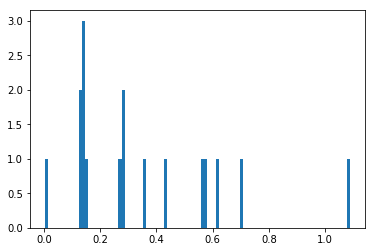

In [15]:
v = dr25Koi.corrected_prad_err1/dr25Koi.koi_prad_err1
plt.hist(v[v<5], 100);

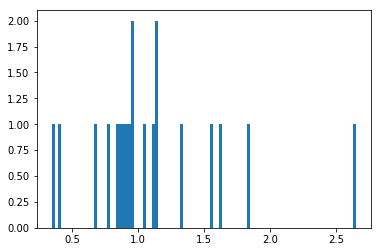

In [16]:
plt.hist(dr25Koi['corrected_prad'][dr25Koi['corrected_prad']<10], 100);

(5, 30)

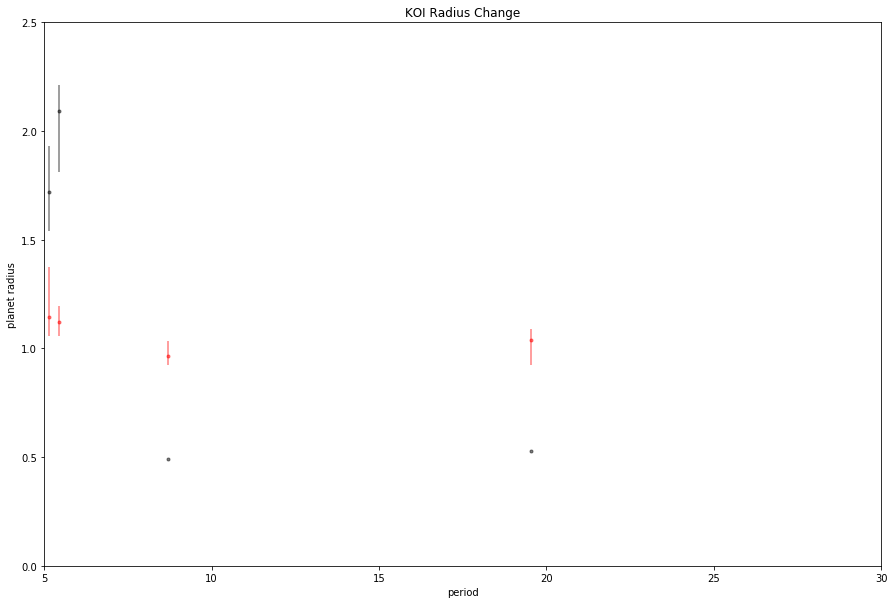

In [17]:
fig, ax = plt.subplots(figsize=(15,10));
ax.errorbar(dr25Koi.koi_period, dr25Koi.koi_prad, 
            yerr = [-dr25Koi.koi_prad_err2, dr25Koi.koi_prad_err1],
            fmt="k.", alpha = 0.5);
ax.errorbar(dr25Koi.koi_period, dr25Koi.corrected_prad, 
            yerr = [-dr25Koi.corrected_prad_err2, dr25Koi.corrected_prad_err1],
            fmt="r.", alpha = 0.5);

plt.xlabel("period");
plt.ylabel("planet radius");
plt.title("KOI Radius Change");
plt.ylim([0, 2.5])
plt.xlim([5, 30])



In [18]:
dr25Fpp = ascii.read("../data/q1_q17_dr25_koifpp.txt")
dr25FppPd = dr25Fpp.to_pandas()

In [19]:
mergedDr25Koi = pd.merge(dr25Koi, dr25FppPd, on="kepoi_name", how="inner")



In [20]:

mergedDr25Koi.loc[:,"reliability"] = 1
    

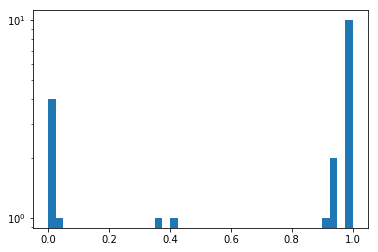

In [21]:
plt.hist(mergedDr25Koi.koi_score, 40);
plt.yscale('log', nonposy='clip')



In [22]:
np.sum(np.isnan(mergedDr25Koi.fpp_prob) & mergedDr25Koi.koi_period > 50)

0

In [23]:
mergedDr25Koi[np.abs(mergedDr25Koi.koi_period - mergedDr25Koi.fpp_koi_period)>1e-2]

,kepid_x,kepoi_name,koi_tce_plnt_num,koi_pdisposition,koi_score,koi_period,koi_max_mult_ev,koi_prad,koi_prad_err1,koi_prad_err2,...,radius_err2,teff,corrected_prad,corrected_prad_err1,corrected_prad_err2,rowid,kepid_y,fpp_koi_period,fpp_prob,reliability


In [24]:
mergedDr25Koi["fpp_prob_use"] = mergedDr25Koi["fpp_prob"]
mergedDr25Koi.fpp_prob_use[np.isnan(mergedDr25Koi.fpp_prob)] = 1
mergedDr25Koi.fpp_prob_use[np.abs(mergedDr25Koi.koi_period - mergedDr25Koi.fpp_koi_period)>1e-2] = 1



/Users/steve/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/steve/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
mergedDr25Koi[np.abs(mergedDr25Koi.koi_period - mergedDr25Koi.fpp_koi_period)>1e-2]

,kepid_x,kepoi_name,koi_tce_plnt_num,koi_pdisposition,koi_score,koi_period,koi_max_mult_ev,koi_prad,koi_prad_err1,koi_prad_err2,...,teff,corrected_prad,corrected_prad_err1,corrected_prad_err2,rowid,kepid_y,fpp_koi_period,fpp_prob,reliability,fpp_prob_use


In [26]:
mergedDr25Koi["totalReliability"] = (1-mergedDr25Koi.fpp_prob_use)*mergedDr25Koi.reliability

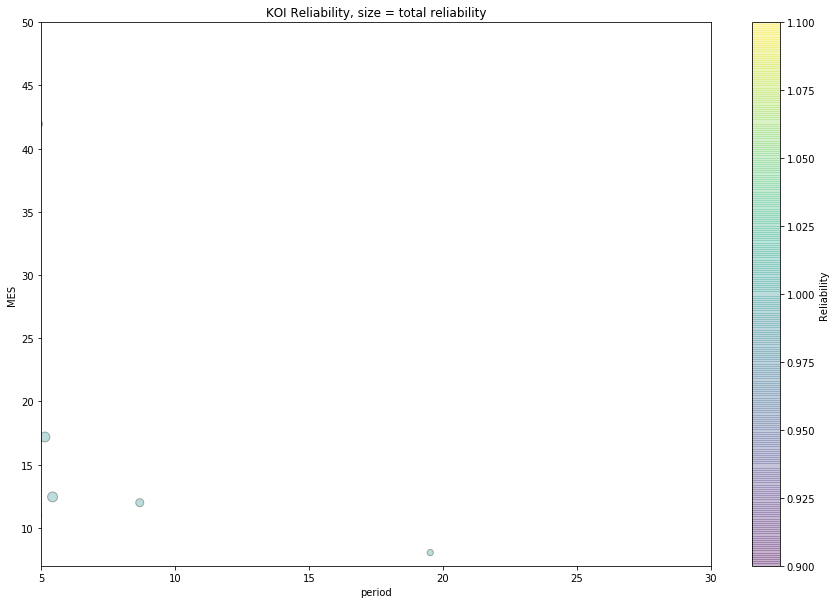

In [27]:
fig, ax = plt.subplots(figsize=(15,10));
scf = ax.scatter(mergedDr25Koi.koi_period, mergedDr25Koi.koi_max_mult_ev, cmap="viridis", 
                 c=mergedDr25Koi.reliability, edgecolors='k', s=100*mergedDr25Koi.totalReliability, alpha = 0.3);
plt.xlabel("period");
plt.ylabel("MES");
plt.title("KOI Reliability, size = total reliability");
plt.ylim([7, 50])
plt.xlim([5, 30])

cbh = plt.colorbar(scf);
cbh.ax.set_ylabel("Reliability");



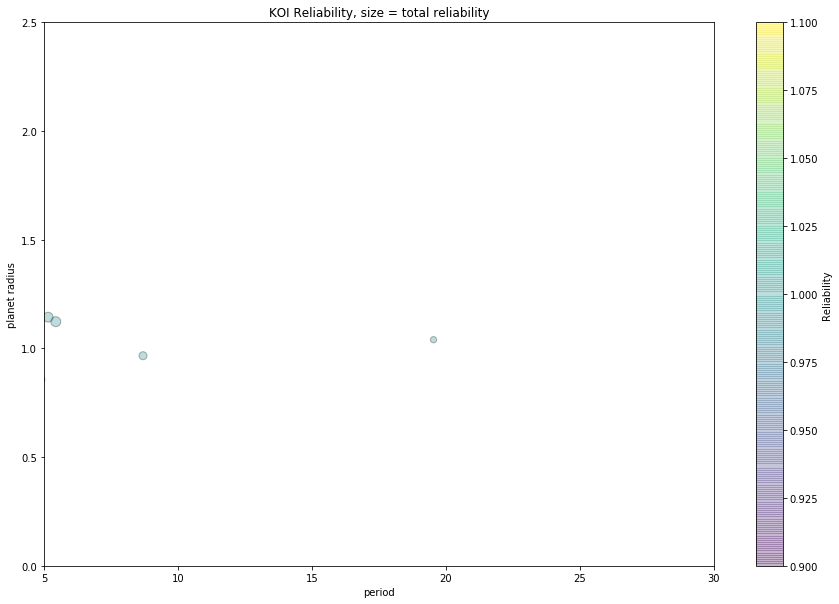

In [28]:
fig, ax = plt.subplots(figsize=(15,10));
scf = ax.scatter(mergedDr25Koi.koi_period, mergedDr25Koi.corrected_prad, cmap="viridis", 
                 c=mergedDr25Koi.reliability, edgecolors='k', s=100*mergedDr25Koi.totalReliability, alpha = 0.3);
plt.xlabel("period");
plt.ylabel("planet radius");
plt.title("KOI Reliability, size = total reliability");
plt.ylim([0, 2.5])
plt.xlim([5, 30])

cbh = plt.colorbar(scf);
cbh.ax.set_ylabel("Reliability");




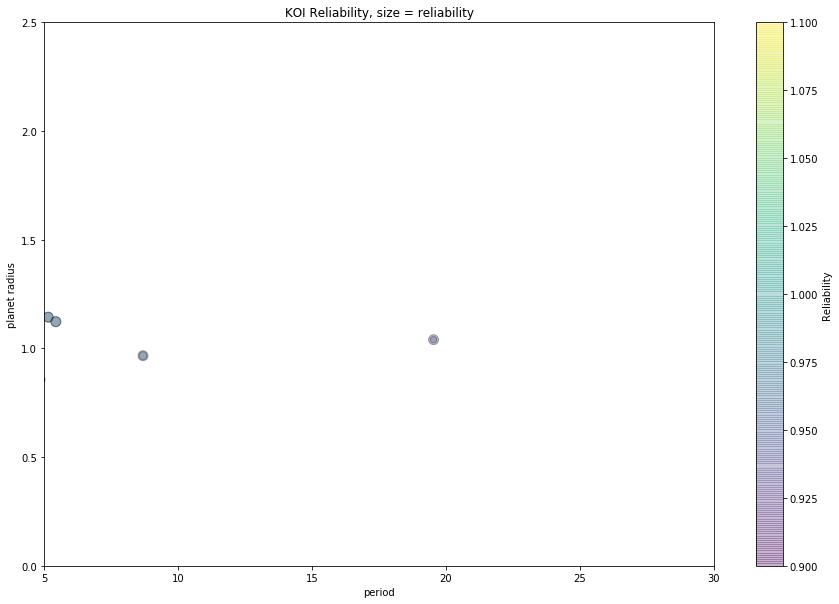

In [29]:
fig, ax = plt.subplots(figsize=(15,10));
scf = ax.scatter(mergedDr25Koi.koi_period, mergedDr25Koi.corrected_prad, cmap="viridis", 
                 c=mergedDr25Koi.reliability, edgecolors='k', s=100*mergedDr25Koi.reliability, alpha = 0.3);
scf = ax.scatter(mergedDr25Koi.koi_period, mergedDr25Koi.corrected_prad, cmap="viridis", 
                 c=mergedDr25Koi.reliability, edgecolors='k', s=100*mergedDr25Koi.totalReliability, alpha = 0.3);

plt.xlabel("period");
plt.ylabel("planet radius");
plt.title("KOI Reliability, size = reliability");
plt.ylim([0, 2.5])
plt.xlim([5, 30])

cbh = plt.colorbar(scf);
cbh.ax.set_ylabel("Reliability");





In [30]:
dataLoc = "../data/"
obsTceList = dataLoc + "kplr_dr25_obs_tces.txt"

obsTcesFull = ascii.read(obsTceList);
obsTcesFullPd = obsTcesFull.to_pandas();

mergedDr25Koi = pd.merge(mergedDr25Koi, obsTcesFullPd[["TCE_ID","Disp"]], on="TCE_ID", how="inner")


In [31]:
# dr25PC = mergedDr25Koi[mergedDr25Koi.koi_pdisposition == "CANDIDATE"]
# dr25FP = mergedDr25Koi[mergedDr25Koi.koi_pdisposition == "FALSE POSITIVE"]
dr25PC = mergedDr25Koi[mergedDr25Koi.Disp == "PC"]
dr25FP = mergedDr25Koi[mergedDr25Koi.Disp == "FP"]

print("There are " + str(len(dr25PC)) + " PCs in " + str(len(dr25CleanStellarIso)) + " observed targets")
print("There are " + str(len(dr25FP)) + " FPs in " + str(len(dr25CleanStellarIso)) + " observed targets")

# remove those with corrected_prad = NAN
dr25PC = dr25PC[~np.isnan(dr25PC.corrected_prad)]
dr25FP = dr25FP[~np.isnan(dr25FP.corrected_prad)]
mergedDr25Koi = mergedDr25Koi[~np.isnan(mergedDr25Koi.corrected_prad)]

print("after removing NaNs")
print("There are " + str(len(dr25PC)) + " PCs in " + str(len(dr25CleanStellarIso)) + " observed targets")
print("There are " + str(len(dr25FP)) + " FPs in " + str(len(dr25CleanStellarIso)) + " observed targets")


There are 14 PCs in 449 observed targets
There are 6 FPs in 449 observed targets
after removing NaNs
There are 14 PCs in 449 observed targets
There are 6 FPs in 449 observed targets


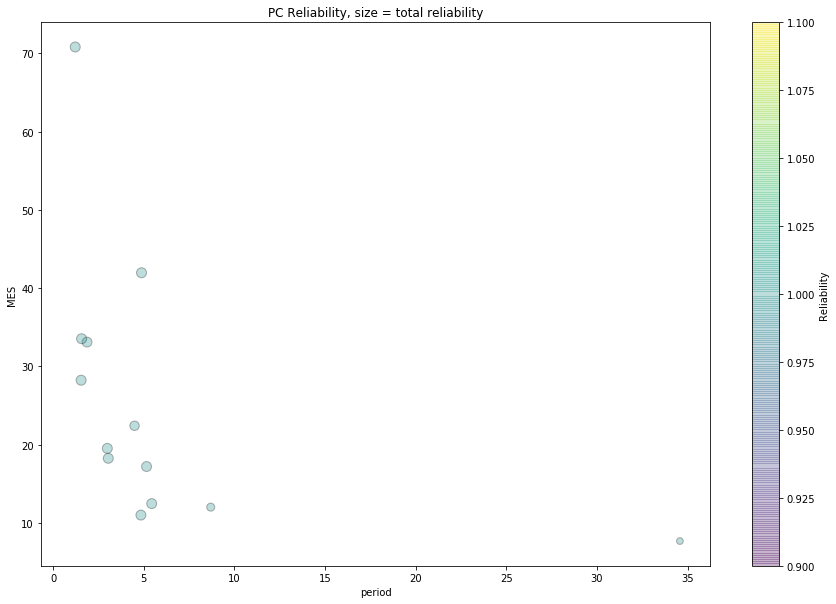

In [32]:
fig, ax = plt.subplots(figsize=(15,10));
scf = ax.scatter(dr25PC.koi_period, dr25PC.koi_max_mult_ev, cmap="viridis", 
                 c=dr25PC.reliability, edgecolors='k', s=100*dr25PC.totalReliability, alpha = 0.3);
plt.xlabel("period");
plt.ylabel("MES");
plt.title("PC Reliability, size = total reliability");
#plt.ylim([7, 30])
#plt.xlim([50, 400])

cbh = plt.colorbar(scf);
cbh.ax.set_ylabel("Reliability");




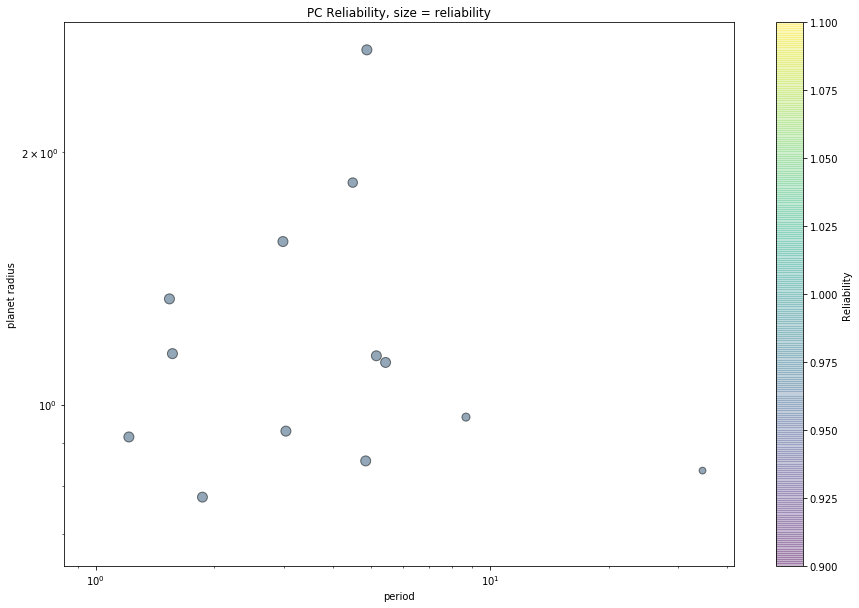

In [33]:
fig, ax = plt.subplots(figsize=(15,10));
scf = ax.scatter(dr25PC.koi_period, dr25PC.corrected_prad, cmap="viridis", 
                 c=dr25PC.reliability, edgecolors='k', s=100*dr25PC.totalReliability, alpha = 0.3);
scf = ax.scatter(dr25PC.koi_period, dr25PC.corrected_prad, s=100*dr25PC.totalReliability, 
                 c=dr25PC.reliability, facecolors='none', edgecolors='k', alpha = 0.3);
plt.yscale('log', nonposy='clip')
plt.xscale('log', nonposx='clip')
plt.xlabel("period");
plt.ylabel("planet radius");
plt.title("PC Reliability, size = reliability");
#plt.ylim([0, 2.5])
#plt.xlim([50, 400])

cbh = plt.colorbar(scf);
cbh.ax.set_ylabel("Reliability");



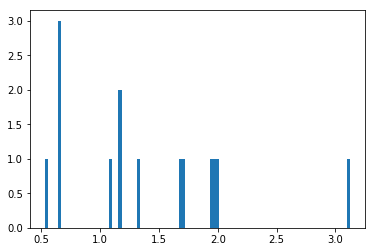

In [34]:
plt.hist(dr25PC.corrected_prad/dr25PC.koi_prad, 100);
#plt.yscale('log', nonposy='clip')



In [35]:
dr25PC.to_csv("koiCatalogs/dr25_GK_PCs_" + htmlLabel + ".csv", index=False)
mergedDr25Koi.to_csv("koiCatalogs/dr25_GK_KOIs_" + htmlLabel + ".csv", index=False)


Text(0.5,1,'FP score distribution')

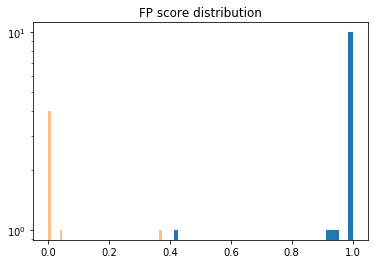

In [36]:
plt.hist(dr25PC.koi_score, 40);
plt.yscale('log', nonposy='clip')
plt.title("PC score distribution")

plt.hist(dr25FP.koi_score, 40, alpha=0.5);
plt.yscale('log', nonposy='clip')
plt.title("FP score distribution")



In [37]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

In [38]:
%%bash -s "$htmlLabel"
jupyter nbconvert --to html makePlanetInput.ipynb
mv makePlanetInput.html htmlArchive/makePlanetInput_$1.html

[NbConvertApp] Converting notebook makePlanetInput.ipynb to html
[NbConvertApp] Writing 527837 bytes to makePlanetInput.html


In [39]:
dr25PC

,kepid_x,kepoi_name,koi_tce_plnt_num,koi_pdisposition,koi_score,koi_period,koi_max_mult_ev,koi_prad,koi_prad_err1,koi_prad_err2,...,corrected_prad_err1,corrected_prad_err2,rowid,kepid_y,fpp_koi_period,fpp_prob,reliability,fpp_prob_use,totalReliability,Disp
1,8561063,K00961.03,2,CANDIDATE,1.000,1.865114,33.096786,0.66,0.17,-0.08,...,0.022670,-0.089316,1738,8561063,1.865,0.024000,1,0.024000,0.976000,PC
2,8561063,K00961.01,1,CANDIDATE,1.000,1.213770,70.819550,0.78,0.20,-0.09,...,0.027342,-0.122816,1736,8561063,1.214,0.000060,1,0.000060,0.999940,PC
3,7304449,K01702.01,1,CANDIDATE,0.999,1.538181,28.219137,1.00,0.23,-0.18,...,0.082524,-0.263465,2585,7304449,1.538,0.000870,1,0.000870,0.999130,PC
4,8733898,K02842.01,1,CANDIDATE,1.000,1.565413,33.523926,1.73,0.22,-0.19,...,0.060015,-0.033992,3977,8733898,1.565,0.001000,1,0.001000,0.999000,PC
5,8733898,K02842.02,3,CANDIDATE,0.992,5.148923,17.186102,1.72,0.21,-0.18,...,0.228572,-0.088887,3978,8733898,5.149,0.020000,1,0.020000,0.980000,PC
6,8733898,K02842.03,2,CANDIDATE,0.947,3.036209,18.237106,1.40,0.17,-0.15,...,0.047261,-0.037074,3979,8733898,3.036,0.006500,1,0.006500,0.993500,PC
8,6444896,K03138.01,1,CANDIDATE,1.000,8.689108,11.992775,0.49,0.00,0.00,...,0.067505,-0.043770,3907,6444896,8.689,0.360000,1,0.360000,0.640000,PC
10,9730163,K02704.01,1,CANDIDATE,1.000,4.871224,41.956470,1.56,0.70,-0.23,...,0.300339,-0.252082,4015,9730163,4.871,0.000022,1,0.000022,0.999978,PC
11,9730163,K02704.02,2,CANDIDATE,0.939,2.984158,19.508406,0.92,0.42,-0.14,...,0.059215,-0.111645,4016,9730163,2.984,0.004400,1,0.004400,0.995600,PC
13,6776555,K05327.01,1,CANDIDATE,1.000,5.433613,12.448482,2.09,0.12,-0.28,...,0.074053,-0.064203,5628,6776555,5.434,0.010000,1,0.010000,0.990000,PC
